In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
from pathlib import Path
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow import keras
from keras import optimizers
%load_ext tensorboard
%matplotlib inline


Bad key text.latex.preview in file C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, 

In [2]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [3]:
# Download ETH Data
ethdata = yf.download("ETH-USD", start="2020-04-08", end="2022-04-08")
eth_df = pd.DataFrame(ethdata)
eth_df.drop(columns=['Adj Close'],inplace=True)

eth_df.head(20)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-04-08,165.240326,173.210266,164.493195,172.641739,17063110836
2020-04-09,172.761261,172.897781,167.987122,170.807144,14901696210
2020-04-10,170.829269,170.949768,154.914474,158.412445,17980944616
2020-04-11,158.538986,161.167572,155.298340,158.216019,13555089447
2020-04-12,158.232391,164.516953,156.320511,161.142426,15123721386
2020-04-13,160.720673,160.749695,151.614487,156.279556,16465282133
2020-04-14,156.355957,160.944275,155.865936,157.596390,14723156630
2020-04-15,157.565643,160.711121,152.802841,153.286896,14171753737
2020-04-16,153.200424,173.157272,150.359421,172.157379,22910469236


<AxesSubplot:xlabel='Date'>

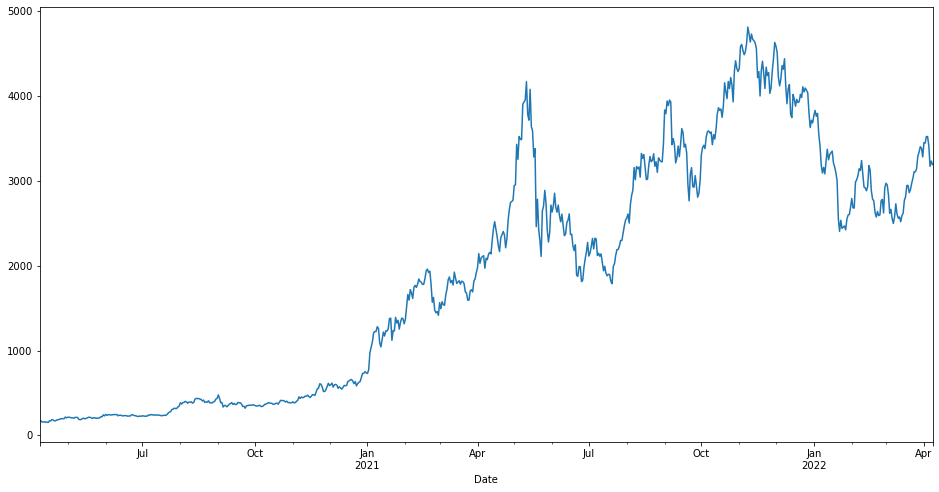

In [4]:
eth_df.Close.plot(figsize=(16, 8))

In [5]:
def window_data(eth_df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(eth_df) - window):
        features = eth_df.iloc[i : (i + window), feature_col_number]
        target = eth_df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 10

feature_column = 3
target_column = 3
X, y = window_data(eth_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[172.64173889 170.80714417 158.41244507 158.21601868 161.14242554
  156.27955627 157.59638977 153.28689575 172.15737915 171.63858032]
 [170.80714417 158.41244507 158.21601868 161.14242554 156.27955627
  157.59638977 153.28689575 172.15737915 171.63858032 186.91400146]
 [158.41244507 158.21601868 161.14242554 156.27955627 157.59638977
  153.28689575 172.15737915 171.63858032 186.91400146 181.61495972]
 [158.21601868 161.14242554 156.27955627 157.59638977 153.28689575
  172.15737915 171.63858032 186.91400146 181.61495972 172.29716492]
 [161.14242554 156.27955627 157.59638977 153.28689575 172.15737915
  171.63858032 186.91400146 181.61495972 172.29716492 172.73770142]] 

y sample values:
[[186.91400146]
 [181.61495972]
 [172.29716492]
 [172.73770142]
 [182.59957886]]


In [7]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [8]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [9]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.00482014]
  [0.00436325]
  [0.00127647]
  [0.00122755]
  [0.00195634]
  [0.00074529]
  [0.00107324]
  [0.        ]
  [0.0001298 ]
  [0.        ]]

 [[0.00436325]
  [0.00127647]
  [0.00122755]
  [0.00195634]
  [0.00074529]
  [0.00107324]
  [0.        ]
  [0.00469951]
  [0.        ]
  [0.00382166]]

 [[0.00127647]
  [0.00122755]
  [0.00195634]
  [0.00074529]
  [0.00107324]
  [0.        ]
  [0.00469951]
  [0.00457031]
  [0.00382166]
  [0.00249593]]

 [[0.00122755]
  [0.00195634]
  [0.00074529]
  [0.00107324]
  [0.        ]
  [0.00469951]
  [0.00457031]
  [0.0083745 ]
  [0.00249593]
  [0.00016477]]

 [[0.00195634]
  [0.00074529]
  [0.00107324]
  [0.        ]
  [0.00469951]
  [0.00457031]
  [0.0083745 ]
  [0.00705483]
  [0.00016477]
  [0.00027498]]] 

X_test sample values:
[[[0.76495927]
  [0.73393138]
  [0.77633682]
  [0.76981258]
  [0.76547912]
  [0.76482454]
  [0.81696322]
  [0.91685215]
  [0.90550281]
  [0.94293649]]

 [[0.73393138]
  [0.77633682]
  [0.769812

In [10]:
# Define the Gradient Recurrent Units (GRU) model.
def model_builder(hp):
    model = Sequential()

    hp_units = hp.Int('units', min_value=2, max_value=218, step=32)
    dropout_fraction = 0.2
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Layer 1
    model.add(GRU(
        units=hp_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))
    # Layer 2
    model.add(GRU(units=hp_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    # Layer 3
    model.add(GRU(units=hp_units))
    model.add(Dropout(dropout_fraction))
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mean_squared_error",metrics=['accuracy'])
    model.summary()
    return model

In [11]:
import shutil

dir_path = 'my_dir'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

In [12]:
tuner = kt.Hyperband(model_builder,
                     objective = kt.Objective("val_loss", direction="min"),
                     max_epochs=40,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 20 Complete [00h 00m 05s]
val_loss: 0.008051968179643154

Best val_loss So Far: 0.0021836997475475073
Total elapsed time: 00h 01m 41s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 66 and the optimal learning rate for the optimizer
is 0.01.



In [13]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(max(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 10, 66)            13662     
                                                                 
 dropout_3 (Dropout)         (None, 10, 66)            0         
                                                                 
 gru_4 (GRU)                 (None, 10, 66)            26532     
                                                                 
 dropout_4 (Dropout)         (None, 10, 66)            0         
                                                                 
 gru_5 (GRU)                 (None, 66)                26532     
                                                                 
 dropout_5 (Dropout)         (None, 66)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [14]:
# Evaluate the model
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)


7/7 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.0000e+00
[test loss, test accuracy]: [0.003078290494158864, 0.0]


In [15]:
# Make some predictions
predicted = hypermodel.predict(X_test)

In [16]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [17]:
# Create a DataFrame of Real and Predicted values
crypto = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = eth_df.index[-len(real_prices): ])
crypto.head()

,Real,Predicted
Date,,
2021-09-04,3887.828369,3557.447754
2021-09-05,3952.133545,3656.987305
2021-09-06,3928.379395,3733.550293
2021-09-07,3426.394287,3788.386719
2021-09-08,3497.315186,3789.281738


<AxesSubplot:xlabel='Date'>

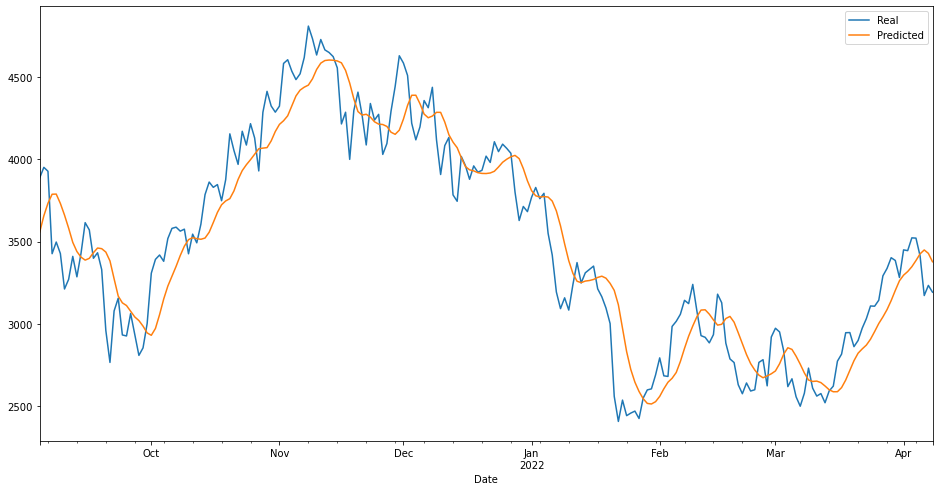

In [20]:
# Plot the real vs predicted prices as a line chart
plt = crypto.plot(figsize = (16,8))
plt.get_figure().savefig("GRU.png")
plt

In [19]:
from sklearn import metrics

print(f'Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predicted), 4))
print(f'Mean Squared Error:', round(metrics.mean_squared_error(y_test, predicted), 4))
print(f'Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predicted)), 4))
print(f'(R^2) Score:', round(metrics.r2_score(y_test, predicted), 4))
errors = abs(predicted - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.0452
Mean Squared Error: 0.0031
Root Mean Squared Error: 0.0555
(R^2) Score: 0.8793
Accuracy: 94.26 %.
